# 混合ガウスモデル(Gaussian Mixture Model, GMM)

混合ガウスモデルは、以下の式で表される確率モデルで、多峰性のあるデータを表現するのに適している。

$$
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
$$

なんのことはない、複数のガウス分布の重ね合わせになっているだけだ。
ただし、ガウス分布の扱いの簡単さを残しつつ、より複雑な分布を表現できるようになる。

単一の正規分布との大きな違いは、その表現できる分布の形状にあるが、実用面における違いは、パラメータ推定にかかる難しさである。
確率分布の章で、単一の多次元正規分布の最尤推定の式を導出したが、混合ガウスモデルの場合は、最尤推定の式を解析的に解くことはできず、以降に述べるEMアルゴリズムを用いて、反復的にパラメータを推定する必要がある。

## KLダイバージェンス

EMアルゴリズムの説明をするために少し数学的な準備をしておく。

2つの確率分布 \(P\) と \(Q\) の間の差異を測る指標として、KLダイバージェンス(Kullback-Leibler divergence)がある。
これは、以下の式で定義される。

$$
D_{KL}(P || Q) = \int p(x) \log \frac{p(x)}{q(x)} dx
$$

離散的な場合は、積分が和に置き換わる。
KLダイバージェンスは、非負であり、\(P\) と \(Q\) が同じ分布である場合にのみゼロになる。
また、非対称であり、一般に $D_{KL}(P || Q) \neq D_{KL}(Q || P)$ である。つまり、KLダイバージェンスは距離の概念は満たさない。

離散的な場合を例に、シンプルな例を考えてみよう。

じゃんけんの手を出す確率がそれぞれ

- Aさん: グー 0.5, チョキ 0.3, パー 0.2
- Bさん: グー 0.2, チョキ 0.2, パー 0.7
- Cさん: グー 0.4, チョキ 0.4, パー 0.2

であるとする。

このとき、ぱっと見で、AさんとCさんは似ているが、Bさんは違うな、と思う。
KLダイバージェンスを計算してみよう。

$$
\begin{align*}
D_{KL}(A || B) & = 0.5 \log \frac{0.5}{0.2} + 0.3 \log \frac{0.3}{0.2} + 0.2 \log \frac{0.2}{0.7} \approx 0.364\\
D_{KL}(A || C) & = 0.5 \log \frac{0.5}{0.4} + 0.3 \log \frac{0.3}{0.4} + 0.2 \log \frac{0.2}{0.2} \approx 0.085\\
D_{KL}(B || C) & = 0.2 \log \frac{0.2}{0.4} + 0.2 \log \frac{0.2}{0.4} + 0.7 \log \frac{0.7}{0.2} \approx 0.530
\end{align*}
$$

AさんとCさんのKLダイバージェンスが最も小さく、Bさんは他の2人とのKLダイバージェンスが大きいことがわかる。
今の場合は離散的だが、連続的な場合も、このKLダイバージェンスを用いて、2つの分布の差異を測ることができそうだ。


## EMアルゴリズム

EMアルゴリズムは、EステップとMステップを交互に繰り返すことで、隠れ変数を含む確率モデルのパラメータを推定する手法である。
混合ガウスモデルだけでなく、**潜在変数(latent variable)** を含む様々な確率モデルに適用できる。

まずは一般論からスタートして、徐々に混合ガウスモデルに話を戻す流れで説明する。

### 潜在変数

潜在変数とは、観測されない変数のことで、データの生成過程に関与しているが、直接観測されない。
我々が観測できるのは、観測変数(observed variable)であり、背後には潜在変数が存在している、というのが基本的なアイデアである。

たとえば、学生の試験の点数（観測変数）があるとする。点数そのものは見えるが、その背後には「理解度」「集中力」「睡眠時間」
といった直接観測できない要因がある。これらが試験結果に影響しているが、教員が観測できるのは点数という観測データだけである。
この「理解度」や「集中力」のように、背後で観測データを生み出している隠れた要因が潜在変数である。

別の例として、たとえば100×100画素 RGB３色で表現されるたくさんの花の画像を考えてみよう。
これらの花の画像は30000次元の数値データ(ベクトル)として表現することができるわけだが、
花の画像は30,000次元の空間をランダムに埋め尽くしているわけではなく、同じ種類の花は「近い場所」に集まって分布しているはずである。花の種類によって分布の形も異なるだろう。
その背後には「花の種類」「花びらの形」「色の傾向」といった潜在変数が存在していると考えられる。


### ELBO (Evidence Lower Bound; エビデンス下界)


観測できる確率変数を $x$とし、潜在変数を $z$ とする。
このとき、パラメータ$\theta$で表される確率モデルの対数尤度は、以下のように書ける。

$$
\log p_{\theta}(x) = \log \sum_{z} p_{\theta}(x, z)
$$

$z$が離散的である場合を考えたが、連続的である場合は、和が積分に置き換わる:

$$
\log p_{\theta}(x) = \log \int p_{\theta}(x, z) dz
$$


また、上では簡単のため$x,z$が1つずつしかない場合を考えたが、実際には複数の観測データがある場合も同様である。

上の式の意味するところは、観測されたデータ$x$を説明する確率分布$p_{\theta}$を、パラメータ$\theta$を変化させながら、最も観測データをよく説明するように調整したい。
その際に、$p_\theta(x)$が、潜在変数$z$に関して周辺化(和または積分)されていることを意味する。

とくに、データセット $\mathcal{D} = \{x^{(1)}, x^{(2)}, \ldots, x^{(N)}\}$ があった場合、対数尤度は以下のようになる。

$$
\log p_{\theta}(\mathcal{D}) = \sum_{i=1}^{N} \log p_{\theta}(x^{(i)}) = \sum_{i=1}^{N} \log \sum_{z^{(i)}} p_{\theta}(x^{(i)}, z^{(i)})
$$

この対数尤度を最大化したいわけだが、上の式はいわゆるlog-sumの形、対数の中に和が入っている形をしているため、直接的に最大化することが難しい。
これを解決するために、変分分布 \(q(z)\) を導入する。この変分分布は、潜在変数 \(z\) の近似的な分布を表すもので、任意に選ぶことができる(とはいえ、ガウス分布など簡単な分布を選ぶことが多い)。

この変分分布を用いて、対数尤度の下界を導出する。

$$
\begin{align*}
\log p_{\theta}(x) & = \log \sum_{z} p_{\theta}(x, z) \\
& = \log \sum_{z} q(z) \frac{ p_{\theta}(x, z) }{ q(z) } 
& \geq \sum_{z} q(z) \log \frac{ p_{\theta}(x, z) }{ q(z) } 
\end{align*}
$$

最後の不等式は、Jensenの不等式を用いて導出される。この右辺がELBO (Evidence Lower Bound; エビデンス下界)である。

$$
\mathcal{L}(q, \theta) = \sum_{z} q(z) \log \frac{ p_{\theta}(x, z) }{ q(z) }
$$

事後分布 $p_{\theta}(z | x)$ と変分分布 $q(z)$ のKLダイバージェンスを考えると、以下の関係が成り立つ。


$$
\begin{align*}
\mathcal{L}(q, \theta) & = \sum_{z} q(z) \log \frac{ p_{\theta}(x, z) }{ q(z) } \\
& = \sum_{z} q(z) \log \frac{ p_{\theta}(z | x) p_{\theta}(x) }{ q(z) } \\
& = - \mathcal{D}_{KL}( q(z) || p_{\theta}(z | x) ) + \log p_{\theta}(x)
\end{align*}    
$$

ここから、

$$
\log p_{\theta}(x) = \mathcal{L}(q, \theta) + \mathcal{D}_{KL}( q(z) || p_{\theta}(z | x) )
$$

KLダイバージェンスは非負であるため、ELBOは対数尤度の下界であり、ELBOの最大化と事後分布と変分分布のKLダイバージェンスの最小化は同値であることがわかる。

## EMアルゴリズムの概要

上のELBO $\mathcal{L}(q, \theta)$は、変分分布$q$とパラメータ$\theta$の両方に依存している。
EMアルゴリズムは、以下の2つのステップを交互に繰り返すことで、ELBOを最大化する。

1. Eステップ: 現在のパラメータ$\theta$を用いて、潜在変数$z$の事後分布$p_{\theta}(z | x)$を計算する。
2. Mステップ: Eステップで得られた事後分布を用いて、ELBOを最大化するようにパラメータ$\theta$を更新する。



## EMアルゴリズムを用いた混合ガウスモデルのパラメータ推定

初めに、各ガウス分布のパラメータを $\boldsymbol{\mu}_k$ (平均)、$\boldsymbol{\Sigma}_k$ (共分散行列)、および混合係数 $\pi_k$ (各ガウス分布の寄与度) とする。

* **Eステップ**: 現在のパラメータを用いて、各データ点$n$がどのガウス分布$k$に属するかの確率を計算する。
    
    $$
    r_{nk} = \frac{\pi_k \mathcal{N}(\boldsymbol{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{
        \sum_j \pi_j  \mathcal{N}(\boldsymbol{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)
    }
    $$

* **Mステップ**: Eステップで得られた確率$r$を用いて、ガウス分布のパラメータ $\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k, \pi_k$ を更新する。

    $$
    \boldsymbol{\mu}_k = \frac{1}{N_k} \sum_n r_{nk} \boldsymbol{x}_n, \quad
    \boldsymbol{\Sigma}_k = \frac{1}{N_k} \sum_n r_{nk} (\boldsymbol{x}_n - \boldsymbol{\mu}_k)(\boldsymbol{x}_n - \boldsymbol{\mu}_k)^\top, \quad
    \pi_k = \frac{N_k}{N}
    $$

この逐次更新によって対数尤度の最大化を図り、収束するまでEステップとMステップを繰り返す。
対数尤度は以下のように表される。

$$
\mathcal{L}(\boldsymbol{\theta}) = \sum_n \log \left( \sum_k \pi_k \mathcal{N}(\boldsymbol{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right)
$$


Converged at iteration 57


Estimated mixing coefficients (phi): [0.3103679  0.30013538 0.38949671]
Estimated means (mu):
 [[ 0.08871446  0.04564594]
 [-3.08442868  3.07309071]
 [ 3.05915799  3.15711097]]
Estimated covariances (sigma):
 [[[ 1.01691342  0.38486941]
  [ 0.38486941  0.98651172]]

 [[ 1.44451192  0.28724678]
  [ 0.28724678  0.91035083]]

 [[ 1.09349783 -0.24274844]
  [-0.24274844  1.27556857]]]


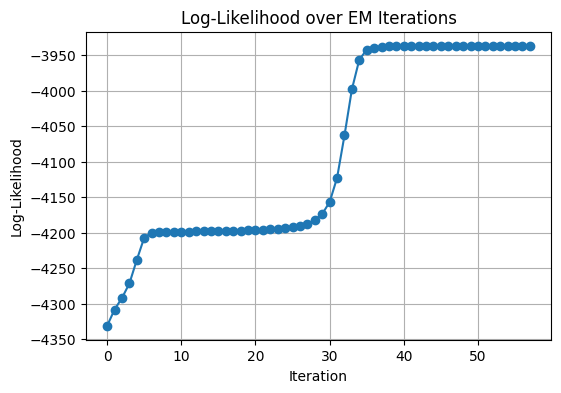

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------
# データ生成 (Ground Truth)
# ----------------------------
np.random.seed(42)

true_means = np.array([[0, 0], [3, 3], [-3, 3]])
true_covs = [
    np.array([[1, 0.3], [0.3, 1]]),
    np.array([[1, -0.2], [-0.2, 1.5]]),
    np.array([[1.5, 0.4], [0.4, 1]])
]
true_weights = np.array([0.3, 0.4, 0.3])

n_samples = 10**3
X = np.vstack([
    np.random.multivariate_normal(mean, cov, int(w * n_samples))
    for mean, cov, w in zip(true_means, true_covs, true_weights)
])

# ----------------------------
# ガウス分布のPDF
# ----------------------------
def gaussian_pdf(x, mean, cov):
    d = x.shape[1]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * det)
    diff = x - mean
    return norm_const * np.exp(-0.5 * np.sum(diff @ inv * diff, axis=1))

# ----------------------------
# プロット: データと推定されたガウス分布の等高線
# ----------------------------
def plot_gaussian_ellipse(mean, cov, ax, color='red'):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(vals)
    ellip = Ellipse(xy=mean, width=width, height=height,
                    angle=angle, edgecolor=color, fc='None', lw=2)
    ax.add_artist(ellip)

def snapshot_gaussians(X, mu, sigma, K, iteration):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

    colors = ["red", "green", "blue"]
    for j in range(K):
        plot_gaussian_ellipse(mu[j], sigma[j], plt.gca(), color=colors[j])
        plt.scatter(mu[j, 0], mu[j, 1], c=colors[j], marker="x", s=100)    
    plt.title(f"Data and Fitted Gaussian Components @ Iteration = {iteration}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()


# ----------------------------
# EMアルゴリズム (GMM)
# ----------------------------
def EM_GMM(X, K, num_iters=100, tol=1e-5):
    n, d = X.shape
    np.random.seed(11)
    # 初期化
    phi = np.ones(K) / K
    mu = X[np.random.choice(n, K, replace=False)]
    sigma = np.array([np.cov(X, rowvar=False) for _ in range(K)])

    log_likelihoods = []
    snapshots = []

    for iteration in range(num_iters):
        # E-step
        responsibilities = np.zeros((n, K))
        for j in range(K):
            responsibilities[:, j] = phi[j] * gaussian_pdf(X, mu[j], sigma[j])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step
        N_k = responsibilities.sum(axis=0)
        phi = N_k / n
        mu = (responsibilities.T @ X) / N_k[:, np.newaxis]
        for j in range(K):
            diff = X - mu[j]
            sigma[j] = (responsibilities[:, j][:, np.newaxis] * diff).T @ diff / N_k[j]

        # 対数尤度
        ll = np.sum(np.log(np.sum([
            phi[j] * gaussian_pdf(X, mu[j], sigma[j]) for j in range(K)
        ], axis=0)))
        log_likelihoods.append(ll)

        # スナップショット保存
        snapshots.append((mu.copy(), sigma.copy(), iteration))

        # 収束判定
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break

    # アニメーション作成

    fig, ax = plt.subplots(figsize=(5, 5))
    scatter = ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)
    title = ax.set_title("")

    def animate(i):
        ax.clear()
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)
        mu_snap, sigma_snap, iter_snap = snapshots[i]
        colors = ["red", "green", "blue"]
        for j in range(K):
            plot_gaussian_ellipse(mu_snap[j], sigma_snap[j], ax, color=colors[j])
            ax.scatter(mu_snap[j, 0], mu_snap[j, 1], c=colors[j], marker="x", s=100)
        ax.set_title(f"Data and Fitted Gaussian Components @ Iteration = {iter_snap}")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")

    anim = FuncAnimation(fig, animate, frames=len(snapshots), interval=500)
    plt.close(fig)
    display(HTML(anim.to_jshtml()))

    return phi, mu, sigma, responsibilities, log_likelihoods

# ----------------------------
# 実行
# ----------------------------
K = 3
phi, mu, sigma, responsibilities, log_likelihoods = EM_GMM(X, K)

print("Estimated mixing coefficients (phi):", phi)
print("Estimated means (mu):\n", mu)
print("Estimated covariances (sigma):\n", sigma)

# ----------------------------
# プロット: 対数尤度の推移
# ----------------------------
plt.figure(figsize=(6, 4))
plt.plot(log_likelihoods, marker="o")
plt.title("Log-Likelihood over EM Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()


In [ ]:
true_means = np.array([[0, 0], [3, 3], [-3, 3]])
true_covs = [
    np.array([[1, 0.3], [0.3, 1]]),
    np.array([[1, -0.2], [-0.2, 1.5]]),
    np.array([[1.5, 0.4], [0.4, 1]])
]
true_weights = np.array([0.3, 0.4, 0.3])